<a href="https://colab.research.google.com/github/ZOUHDIYassine/ALGO/blob/main/3_strategies/E_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/d9w/evolution/raw/master/imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Algorithms

## Evolving Neural Networks with ES

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson, Yuri Lavinas, Paul Templier | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

In order to visualize the environment in this notebook, you will need to install the following:

In [1]:
!apt-get install -y xvfb python-opengl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


In [2]:
!pip install cma swig pyvirtualdisplay pygame box2d-py==2.3.8

  Using cached cma-4.0.0-py3-none-any.whl.metadata (8.0 kB)
  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
Using cached cma-4.0.0-py3-none-any.whl (283 kB)
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp310-cp310-linux_x86_64.whl size=2376104 sha256=ffec7cf6686109110e5d0f3986718ec7bb80369610e2b438252f5466621030fb
  Stored in directory: /root/.cache/pip/wheels/47/01/d2/6a780da77ccb98b1d2facdd520a8d10838a03b590f6f8d50c0
Successfully built box2d-py
  Attempting uninstall: box2d-py
    Found existing installation: box2d-py 2.3.5
    Uninstalling box2d-py-2.3.5:
      Successfully uninstalled box2d-py-2.3.5


In [3]:
!apt-get update
!apt-get install -y build-essential python3-dev


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 5s (56.5 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to pro

In [4]:
!pip install --upgrade gym

In [5]:
!apt-get install -y swig

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


In [6]:
!pip install Box2D-kengz

In [7]:
!pip install gym[box2d]

  Using cached box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: box2d-py
    Found existing installation: box2d-py 2.3.8
    Uninstalling box2d-py-2.3.8:
      Successfully uninstalled box2d-py-2.3.8


In [8]:
!pip install torch

# <a name="neuroevolution">3.</a> ES for Neuroevolution

Evolutionary strategies are intended for continuous optimization and can easily be applied to the optimization of neural network parameters, or *neuroevolution*.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import numpy as np
import gym

In [10]:
class NeuralNetwork(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_shape, 32)
        self.l2 = nn.Linear(32, 32)
        self.lout = nn.Linear(32, n_actions)

    def forward(self, x):
        x = F.relu(self.l1(x.float()))
        x = F.relu(self.l2(x))
        return self.lout(x)

    def get_params(self):
        p = np.empty((0,))
        for n in self.parameters():
            p = np.append(p, n.flatten().cpu().detach().numpy())
        return p

    def set_params(self, x):
        start = 0
        for p in self.parameters():
            e = start + np.prod(p.shape)
            p.data = torch.FloatTensor(x[start:e]).reshape(p.shape)
            start = e

In [11]:
!pip install pyvirtualdisplay

In [12]:
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


We'll add some visualization functionality to have the environment render directly in the notebook.

In [13]:
from pyvirtualdisplay import Display
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
pydisplay = Display(visible=0, size=(1400, 900))
pydisplay.start()
plt.ion();

Following the framework of evolutionary policy search, we will optimize a neural network representing a policy and maximize the total reward over a single episode using this policy.

In [14]:
def evaluate(ann, env, visul=True):
    obs, info = env.reset(seed=0)
    if visul:
        img = plt.imshow(env.render())
    total_reward = 0
    while True:
        # Output of the neural net
        net_output = ann(torch.tensor(obs))
        # the action is the value clipped returned by the nn
        action = net_output.data.cpu().numpy().argmax()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        if visul:
            img.set_data(env.render())
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        if done:
            break
    return total_reward

We've configured this for discrete action spaces. We can see a random neural network on different environments like `CartPole-v0`, `MountainCar-v0`, and `LunarLander-v2`.

In [15]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)

-434.73778251123355

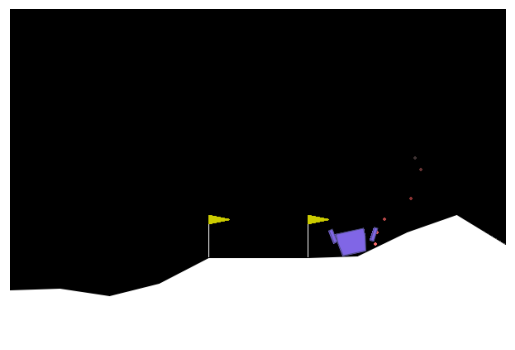

In [16]:
evaluate(ann, env, visul=True)

In order to evolve the parameters of this neural network, we will modify the parameters of the network using `set_params` with the genes of the new individual. In the evolutionary literature, this is referred to as a *direct encoding* as the neural network parameters are directly encoded in the genome.

In [17]:
def fitness(x, ann, env, visul=False):
    ann.set_params(x)
    return -evaluate(ann, env, visul=visul)

In [18]:
p = ann.get_params()
np.shape(p)

(1476,)

We can first observe a random individual $x$.

-434.73778251123355

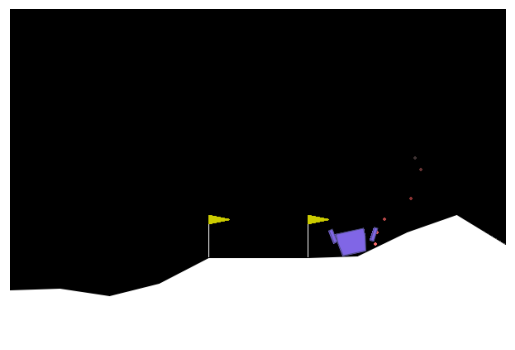

In [19]:
x = np.random.rand(len(p))
-fitness(x, ann, env, visul=True)

Let's try optimizing the policy using the simple $(\mu, \lambda)$ ES we proposed.

In [20]:
def mu_lambda(x, fitness, gens=200, lam=10, alpha=0.2, verbose=False):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        F = np.zeros(lam)
        for i in range(lam):
            ind = x + N[i, :]
            F[i] = fitness(ind)
            if F[i] < f_best:
                f_best = F[i]
                x_best = ind
                if verbose:
                    print(g, " ", f_best)
        fits[g] = f_best
        mu_f = np.mean(F)
        std_f = np.std(F)
        A = F
        if std_f != 0:
            A = (F - mu_f) / std_f
        x = x - alpha * np.dot(A, N) / lam
    return fits, x_best

In [21]:
np.random.seed(654)
env = gym.make('LunarLander-v2', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
x = np.random.randn(len(ann.get_params()))
f = lambda x : fitness(x, ann, env)
fits, x = mu_lambda(x, f, gens=10, lam=10, alpha=0.1, verbose=True)

0   119.05959591305864
0   92.39587218088589
3   20.581424356249684


In [22]:
fits

array([92.39587218, 92.39587218, 92.39587218, 20.58142436, 20.58142436,
       20.58142436, 20.58142436, 20.58142436, 20.58142436, 20.58142436])

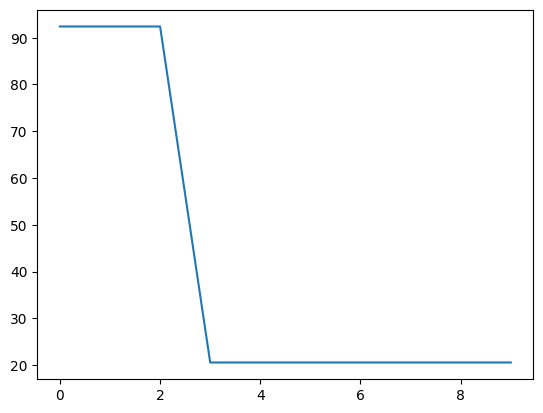

In [23]:
plt.plot(fits);

-20.581424356249684

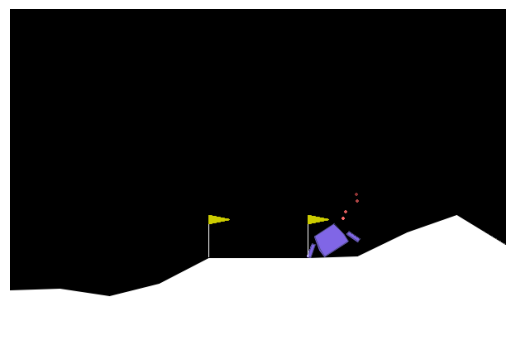

In [24]:
-fitness(x, ann, env, visul=True)

# CMA-ES for Neuroevolution

We will now use CMA-ES for the Lunar Lander problem

In [25]:
import cma
np.random.seed(123)
env = gym.make('LunarLander-v2', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
es = cma.CMAEvolutionStrategy(len(ann.get_params()) * [0], 0.1, {'seed': 123})

(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 1476 (seed=123, Fri Nov  1 21:11:23 2024)


In [26]:
for i in range(20):
    solutions = np.array(es.ask())
    fits = [fitness(x, ann, env) for x in solutions]
    es.tell(solutions, fits)
    es.disp()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     25 -2.200069783769990e+00 1.0e+00 9.94e-02  1e-01  1e-01 0:00.8
    2     50 1.190595959130586e+02 1.0e+00 9.89e-02  1e-01  1e-01 0:01.5
    3     75 1.190595959130586e+02 1.0e+00 9.84e-02  1e-01  1e-01 0:02.1
    9    225 1.190595959130586e+02 1.0e+00 9.58e-02  1e-01  1e-01 0:05.5
   13    325 1.423265051288674e+01 1.0e+00 9.43e-02  9e-02  9e-02 0:10.3
   20    500 6.680270951924129e+00 1.0e+00 9.21e-02  9e-02  9e-02 0:15.6


In [27]:
x = es.result[0]
-fitness(x, ann, env, visul=False)

29.67061082319202

The results on LunarLander clearly show the benefits of CMA-ES; we have found a reasonable policy in a small number of generations. Applying CMA-ES to larger neural networks remains an open challenge, however, due to the vast number of parameters in ANNs. Specifically, CMA-ES calculates the covariance of all parameters, which is $O(n^2)$.

In [28]:
np.shape(es.sm.C)

(1476, 1476)

<div class="alert alert-success">
    <h3>Exercise 1</h3>
    
The network used has 2 layers of 32 neurons each. Try changing this and noticing the impact on the number of total parameters for CMA-ES. How large of a network can CMA-ES optimize?
</div>

<div class="alert alert-success">
    <h3>Exercise 2</h3>
    
Compare the $(1+\lambda)$ ES, $(\mu,\lambda)$ ES, and CMA-ES algorithms on Lunar Lander. Is one significantly better than the others, consistently across different initializations?
</div>